In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read dataset
import pandas as pd
df_train = pd.read_csv("/content/drive/My Drive/Delta One Assessment/D1_Project_train.csv")
print(df_train.shape)
df_test = pd.read_csv("/content/drive/My Drive/Delta One Assessment/D1_Project_test.csv")
print(df_test.shape)

(90000, 68)
(19707, 68)


In [ ]:
# preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
X = df_train.iloc[:,:(-1)]
y = df_train['TARGET']
X_test = df_test.iloc[:,:(-1)]
y_test = df_test['TARGET']

# get a validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_valid.shape)
scaler = preprocessing.StandardScaler().fit(X_train)
X = scaler.transform(X)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)
print(X.shape, X_train.shape, X_valid.shape, X_test.shape)
print(y.shape, y_train.shape, y_valid.shape, y_test.shape)

(63000, 67) (27000, 67)
(90000, 67) (63000, 67) (27000, 67) (19707, 67)
(90000,) (63000,) (27000,) (19707,)


In [ ]:
# Model1 (baseline): OLS linear regression
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
pred = reg.predict(X_valid)
print(pred.shape)
profit = y_valid[pred>0].sum()
print(profit)

(27000,)
6.140718411


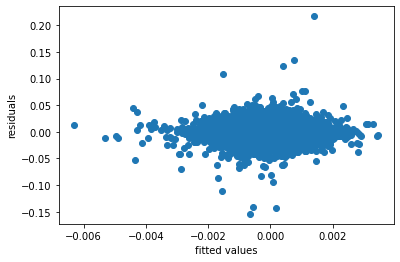

In [ ]:
# plot residuals vs fitted values
import matplotlib.pyplot as plt
fitted = reg.predict(X_train)
plt.scatter(fitted,y_train-fitted)
plt.xlabel('fitted values')
plt.ylabel('residuals')
plt.show()

# no obvious nonlinearity is found

In [ ]:
# Model2: MLP with L2 loss
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import numpy as np
import time
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(0)

input_size = X.shape[1]
hidden_size = 8
batch_size = 4096
ep_num = 200
patience = 20
trigger_times = 0

#network architecture
class Perceptron(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Perceptron, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
            )

    def forward(self, x):
        return self.main(x)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# Define how we load data
class MyDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        feature = self.features[idx, :]
        target = self.targets[idx]
        return feature.astype(np.float32), target.astype(np.float32)

model = Perceptron(input_size, hidden_size).to(device)
print(count_parameters(model))
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay = 0.5)
trainloader = torch.utils.data.DataLoader(MyDataset(X_train,y_train.to_numpy()),
                        batch_size=batch_size, shuffle=True)
validloader = torch.utils.data.DataLoader(MyDataset(X_valid,y_valid.to_numpy()),
                        batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(MyDataset(X_test,y_test.to_numpy()),
                        batch_size=batch_size, shuffle=True)
print(len(trainloader), len(validloader), len(testloader))

# calculate the profit
def evaluation(model,dataloader):
    profit = 0
    for i,data in enumerate(dataloader):
        feature, target = data
        pred = model(feature.to(device))
        profit += target.to(device)[pred.squeeze()>0].sum()
    return profit

cuda:0
553
16 7 5


In [ ]:
start = time.time()
PATH = '/content/drive/My Drive/Delta One Assessment/'+'model2.pth'
best_profit = evaluation(model, validloader)
print('validation set current_profit:', best_profit)
for epoch in range(ep_num):
    loss_total = 0.0
    for i,data in enumerate(trainloader):
        feature, target = data
        pred = model(feature.to(device))
        optimizer.zero_grad()
        loss = ((pred-target.to(device))**2).mean()
        #loss = torch.abs(pred-target.to(device)).mean()
        #loss = torch.maximum(torch.zeros_like(pred).to(device) ,-torch.sign(target.to(device))*(pred)).mean()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()*batch_size
    print('Epoch {}: train loss: {}'.format(epoch, loss_total))
    current_profit = evaluation(model, validloader)
    print('validation set current_profit:', current_profit.item())
    if current_profit < best_profit:
            trigger_times += 1
            print('Trigger Times:', trigger_times)
            if trigger_times >= patience:
                print('Early stopping')
                break
    else:
        best_profit = current_profit
        print('trigger times: 0')
        trigger_times = 0
        torch.save(model.state_dict(), PATH)

print('Time Cost', time.time()-start)

validation set current_profit: tensor(0.3992, device='cuda:0')
Epoch 0: train loss: 8775.787841796875
validation set current_profit: 0.4697624742984772
trigger times: 0
Epoch 1: train loss: 7986.202301025391
validation set current_profit: 0.5380436182022095
trigger times: 0
Epoch 2: train loss: 7233.957061767578
validation set current_profit: 0.5899760723114014
trigger times: 0
Epoch 3: train loss: 6603.230194091797
validation set current_profit: 0.559808075428009
Trigger Times: 1
Epoch 4: train loss: 6041.911468505859
validation set current_profit: 0.5141929388046265
Trigger Times: 2
Epoch 5: train loss: 5527.369171142578
validation set current_profit: 0.44488954544067383
Trigger Times: 3
Epoch 6: train loss: 5081.761505126953
validation set current_profit: 0.45559579133987427
Trigger Times: 4
Epoch 7: train loss: 4676.735046386719
validation set current_profit: 0.5804389119148254
Trigger Times: 5
Epoch 8: train loss: 4293.463623046875
validation set current_profit: 0.6078592538833618

In [ ]:
model.load_state_dict(torch.load(PATH, map_location=torch.device(device)))
model.to(device)
evaluation(model,validloader)

tensor(1.8469, device='cuda:0')